In [ ]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from tensorflow import keras
#usiamo anche le funzioni di keras_cv
!pip install --upgrade pycocotools git+https://github.com/davin11/keras-cv.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/davin11/keras-cv.git to /tmp/pip-req-build-2aq33z78
  Running command git clone --filter=blob:none --quiet https://github.com/davin11/keras-cv.git /tmp/pip-req-build-2aq33z78
  Resolved https://github.com/davin11/keras-cv.git to commit 10fa3be8b7c681e0da0a6002ffd4345b1119706a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for keras-cv: filename=keras_cv-0.4.2-py3-none-any.whl size=706390 sha256=b06563dfd52c539b075b4da46281ca150ea7f7de5775699383b3dd2a300372e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-7jxr3afp/wheels/c6/24/1b/8f18f031f8fdae5a214b9fbba0a61306519716694aded9265e
Successfully built keras-cv


In [ ]:
!echo "check_certificate = off" >> ~/.wgetrc
!wget -q -c https://www.grip.unina.it/download/guide_TF/dogs_vs_cats.zip
!unzip -q -n dogs_vs_cats.zip    #sta caricando e dezzipando sul server di google
#si è creta una cartella train per fare il training e test per fare validation test, vogliamo addestrare la rete per distinguere cani e gatti.


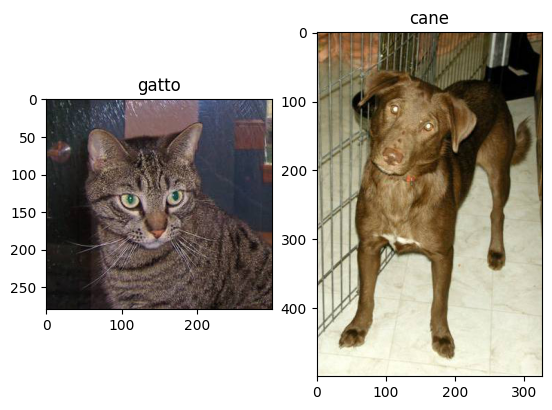

In [ ]:
cat = io.imread('dogs_vs_cats/train/cat/cat.1.jpg')
dog = io.imread('dogs_vs_cats/train/dog/dog.1.jpg')
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cat); plt.title('gatto')
plt.subplot(1,2,2)
plt.imshow(dog); plt.title('cane')
plt.show()
#nota le immagini sono a dimensione diverse, ma le reti sono addestrate per gestire immagini della stessa dimensione, dopo vediamo come fare


In [ ]:
#do il path della cartella e mi da la lista delle immagini di training cpn la relativa classe e  mi fa una tabella informativa di tutte le immagini del training
import keras_cv.utils.image_dataset as image_dataset
table_train = image_dataset.dataframe_from_directory('./dogs_vs_cats/train')
table_train
#sa il nome della classe dal nome della cartella:ogni cartella ha una classe

Found 20000 files belonging to 2 classes.


,image,class
0,./dogs_vs_cats/train/cat/cat.0.jpg,cat
1,./dogs_vs_cats/train/cat/cat.1.jpg,cat
2,./dogs_vs_cats/train/cat/cat.10.jpg,cat
3,./dogs_vs_cats/train/cat/cat.100.jpg,cat
4,./dogs_vs_cats/train/cat/cat.1000.jpg,cat
...,...,...
19995,./dogs_vs_cats/train/dog/dog.9995.jpg,dog
19996,./dogs_vs_cats/train/dog/dog.9996.jpg,dog
19997,./dogs_vs_cats/train/dog/dog.9997.jpg,dog
19998,./dogs_vs_cats/train/dog/dog.9998.jpg,dog


In [ ]:
#tutte le operazioni che faremo sulle immagini di training image_dataset.image_classification_dataset_from_dataframe
batch_size = 8
img_height, img_width = 150, 150

from keras_cv.layers.preprocessing import RandomBrightness, RandomAffineTransf
augmenter = keras.Sequential(layers=[
  RandomBrightness(factor=(-0.1, 0.1), value_range=(0, 255)),
  RandomAffineTransf(zoom_range=(0.8,1.2), horizontal_flip=True)
])

from keras_cv.layers.preprocessing import Resizing
train_dataset = image_dataset.image_classification_dataset_from_dataframe(
  table_train, batch_size=batch_size, shuffle=True,
  pre_batching_processing=Resizing(img_height, img_width),
  post_batching_processing=None,
  include_rescaling=True,
  class_mode='categorical')

For class 'cat', there are 10000 images.
For class 'dog', there are 10000 images.
shuffling with buffer_size 80


forniamo tabella data prima, in che gruppi raggruppare le immagini, shuffle: a fine di ogni epoca le immagini vengono mischiate per introdurre variabilità, poi prima di creare il batch creare faccior esize per impostare le immagini alle stesse dimensioni, poi dopo fatto il batch non fare nulla
e il parametro di rescale per l' ampiezza le immagini nel range da 0 a 255 vengono convertite da 0 a 1 ,e infine il calss mode categorical le immagini sono convertite in formato one hot.

In [ ]:
#dobbiamo fare le stesse operazioni per il validation test
table_valid = image_dataset.dataframe_from_directory('./dogs_vs_cats/validation')
valid_dataset = image_dataset.image_classification_dataset_from_dataframe(
  table_valid, batch_size=batch_size, shuffle=False,
  pre_batching_processing=Resizing(img_height, img_width),
  include_rescaling=True,
  class_mode='categorical')

Found 5000 files belonging to 2 classes.
For class 'cat', there are 2500 images.
For class 'dog', there are 2500 images.


anche qui sono raggruppate a gruppo di 8, non cè bisogno di fare lo shuffle, lo shuffle va fatto sulle immagini da cui si calcola il gradiente.


In [ ]:
#ora dobbiamo definire l'architettura. partiamo da una rete gia addestarta su ImageNet, dobbiamo istanziare ResNet
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False,
  input_shape=(img_width, img_height, 3))

94765736/94765736 [==============================] - 5s 0us/step


 include_top=False il fully conncted di imagenet ha mille uscite e a noi servono solo 2 quindi non prendiamo la parte finale della rete e tralsciamo alnche il global avarage poooling che poi va rimesso


In [ ]:
from tensorflow.keras import layers
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(2, activation='softmax'))
model.summary()
#GlobalAveragePooling2D fa la media per ogni feature map

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


blochhiamo i primi livelli:   così congelo i pesi dei primi 25 livelli


In [ ]:
train_after_layer = 25
for layer in base_model.layers[:train_after_layer]:
  layer.trainable = False
model.summary()
#nota che i parametri su cui viene addestrata la rete scende, invece il numero totale di parametri rimane la stessa


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,399,810
Non-trainable params: 192,000
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
  optimizer=keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), #momentum serve per evitare gradienti bruschi nel calcolo
  metrics=['accuracy', ])


In [ ]:
model.fit(train_dataset, validation_data=valid_dataset, epochs=1, verbose=True, )

2500/2500 [==============================] - 193s 67ms/step - loss: 0.3356 - accuracy: 0.8484 - val_loss: 0.2018 - val_accuracy: 0.9144


In [ ]:
model.save_weights('pesi.hdf5')

In [ ]:
model.load_weights('pesi.hdf5')

In [ ]:
preds = model.predict(valid_dataset)

625/625 [==============================] - 13s 20ms/step


In [ ]:
model.evaluate(valid_dataset)

625/625 [==============================] - 14s 22ms/step - loss: 0.2018 - accuracy: 0.9144


[0.20176322758197784, 0.9143999814987183]